In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import mnist

### Load and normalize the data

In [2]:
print("Getting dataset...")
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Getting dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_images = torch.from_numpy(train_images).float().unsqueeze(1) / 255.0
train_labels = torch.from_numpy(train_labels).long()

test_images = torch.from_numpy(test_images).float().unsqueeze(1) / 255.0
test_labels = torch.from_numpy(test_labels).long()

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
for images, labels in train_loader:
            train_images, train_labels = images.to(device), labels.to(device)

for images, labels in test_loader:
            test_images, test_labels = images.to(device), labels.to(device)

In [5]:
print(f"Count of train dataset: {len(train_loader.dataset)}")
print(f"Count of train dataset: {len(test_loader.dataset)}")

Count of train dataset: 60000
Count of train dataset: 10000


#### Batch from train-data

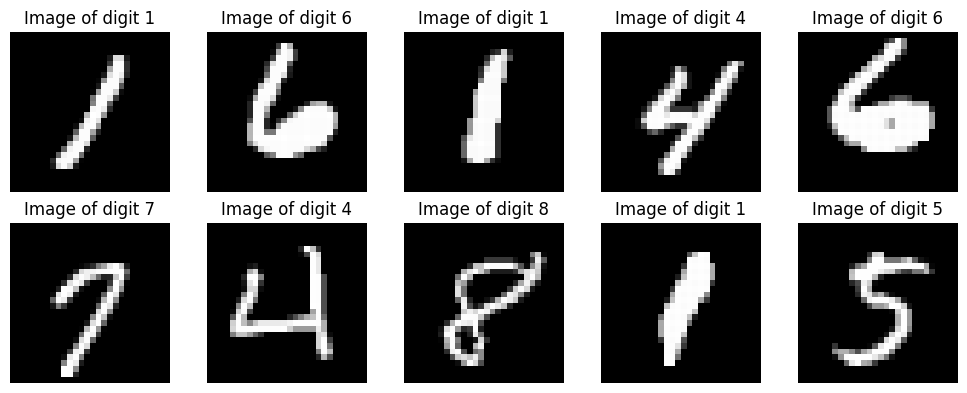

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
images = [train_images[i].detach().cpu().reshape(28,28) for i in range(10)]
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f'Image of digit {train_labels[i]}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Define model

In [7]:
model = nn.Sequential(

    nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32, 32, kernel_size=3, bias=False),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2, bias=False),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(32),
    nn.Dropout(0.4),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.ReLU(),
    nn.Dropout(0.4),

    # Classifier
    nn.Flatten(),
    nn.Linear(64 * 1 * 1, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 10)
)

In [8]:
from torchsummary import summary

summary(model.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
            Conv2d-4           [-1, 32, 26, 26]           9,216
              ReLU-5           [-1, 32, 26, 26]               0
       BatchNorm2d-6           [-1, 32, 26, 26]              64
            Conv2d-7           [-1, 32, 13, 13]          25,600
              ReLU-8           [-1, 32, 13, 13]               0
         MaxPool2d-9             [-1, 32, 6, 6]               0
      BatchNorm2d-10             [-1, 32, 6, 6]              64
          Dropout-11             [-1, 32, 6, 6]               0
           Conv2d-12             [-1, 64, 3, 3]          18,432
             ReLU-13             [-1, 64, 3, 3]               0
        MaxPool2d-14             [-1, 6

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
print("Training started...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

Training started...
Epoch 1/5, Loss: 0.4496
Epoch 2/5, Loss: 0.1871
Epoch 3/5, Loss: 0.1530
Epoch 4/5, Loss: 0.1357
Epoch 5/5, Loss: 0.1189


### Evaluate the model

In [11]:
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.14%


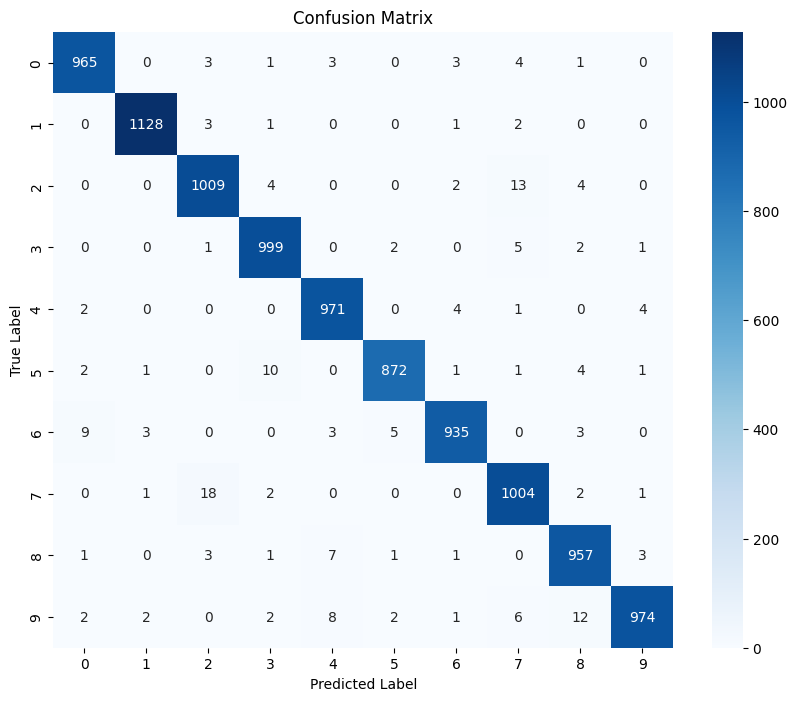

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

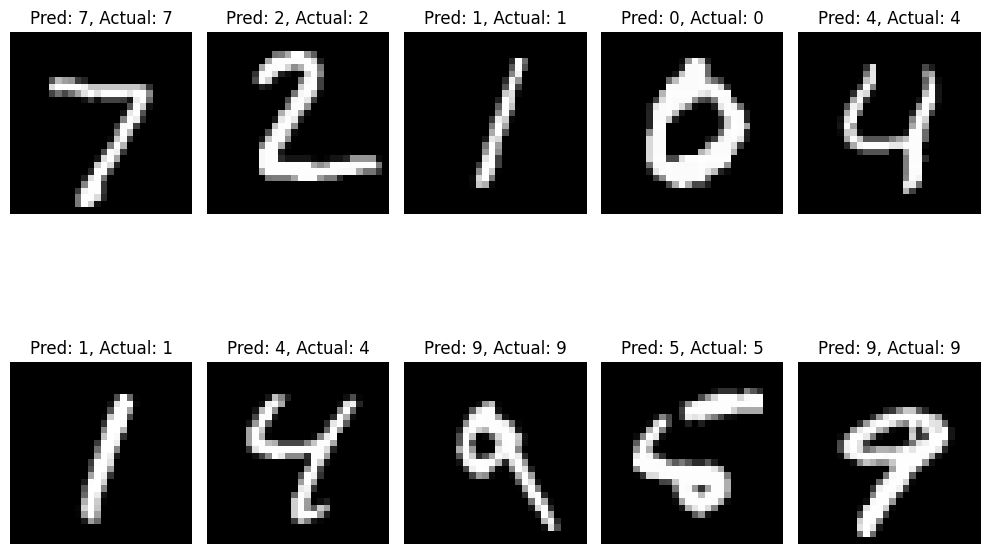

In [20]:
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i].detach().cpu().squeeze().numpy(), cmap='gray')
        ax.set_title(f'Pred: {preds[i].item()}, Actual: {labels[i].item()}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Misclassified images

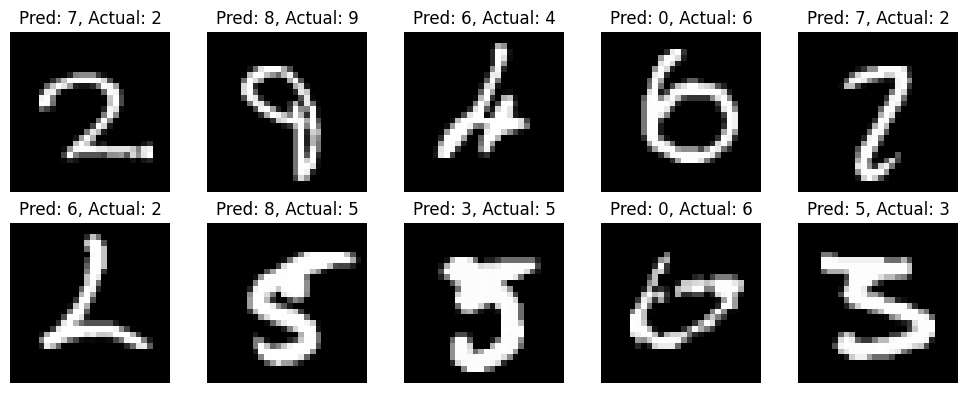

In [17]:
model.eval()
mispredicted_images = []
mispredicted_labels = []
mispredicted_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        mispredicted_indices = (preds != labels).nonzero(as_tuple=True)[0]

        for idx in mispredicted_indices:
            if len(mispredicted_images) < 10:
                mispredicted_images.append(images[idx].cpu().squeeze().numpy())
                mispredicted_labels.append(labels[idx].item())
                mispredicted_preds.append(preds[idx].item())
            else:
                break
        if len(mispredicted_images) >= 10:
            break

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < len(mispredicted_images):
        ax.imshow(mispredicted_images[i], cmap='gray')
        ax.set_title(f'Pred: {mispredicted_preds[i]}, Actual: {mispredicted_labels[i]}')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Visualize model

In [28]:
from torchviz import make_dot

input_size=(1, 1, 28, 28)
output_file="model_graph"
model.to(device)
model.eval()
dummy_input = torch.randn(*input_size).to(device)
output = model(dummy_input)

dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render(output_file)
print(f"Model graph saved as {output_file}.png")

Model graph saved as model_graph.png
